In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical

import numpy as np
from matplotlib import pyplot as plt

import cv2
import os
from google.colab import files

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive/NN_HW2_Face_Emotion/TRAIN')
os.chdir('/content/drive/MyDrive/NN_HW2_Face_Emotion/TUNE')

In [4]:
train='/content/drive/MyDrive/NN_HW2_Face_Emotion/TRAIN'
tune='/content/drive/MyDrive/NN_HW2_Face_Emotion/TUNE'


In [5]:

# Function to load and augment images
def load_and_augment_images(folder_path):
    images = []
    labels = []

    # Map emotion labels to numeric values
    emotion_mapping = {
        'happy': 0,
        'anger': 1,
        'contempt': 2,
        'disgust': 3,
        'fear': 4,
        'neutral': 5,
        'sad': 6,
        'surprise': 7
    }

    # ImageDataGenerator for augmentations
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )

    for emotion_folder in os.listdir(folder_path):
        emotion_label = emotion_mapping[emotion_folder]
        emotion_folder_path = os.path.join(folder_path, emotion_folder)

        for filename in os.listdir(emotion_folder_path):
            image_path = os.path.join(emotion_folder_path, filename)
            image = cv2.imread(image_path)

            # Normalize the image
            normalized_image = image / 255.0

            # Reshape the image to (1, height, width, channels) for augmentation
            reshaped_image = normalized_image.reshape((1,) + normalized_image.shape)

            # Apply augmentations
            # augmented_images = datagen.flow(reshaped_image, batch_size=1)
            augmented_images = reshaped_image

            for i in range(1):  # Augment each image 1 time
                augmented_image = augmented_images[0]
                images.append(augmented_image)
                labels.append(emotion_label)

    return np.array(images), np.array(labels)


# Load and augment images
augmented_train_images, augmented_train_labels = load_and_augment_images(train)


In [6]:

# Assuming you have loaded your images and labels into the variables `augmented_images` and `augmented_labels`

# Combine images and labels
combined_data = list(zip(augmented_train_images, augmented_train_labels))

# Define the percentage to shuffle (e.g., 2%)
shuffle_percentage = 2

# Shuffle a percentage of data within each class
shuffled_data = []

# Number of classes
num_classes = len(np.unique(augmented_train_labels))

for i in range(num_classes):
    # Extract data for the current class
    class_data = [(img, label) for img, label in combined_data if label == i]

    # Determine the number of samples to shuffle (5% of the class data)
    num_samples_to_shuffle = int(len(class_data) * (shuffle_percentage / 100))

    # Randomly select the samples to shuffle
    samples_to_shuffle = np.random.choice(len(class_data), num_samples_to_shuffle, replace=False)

    # Shuffle the order of the selected samples
    class_data_shuffled = [class_data[idx] for idx in samples_to_shuffle]
    np.random.shuffle(class_data_shuffled)

    # Append the shuffled data to the final list
    shuffled_data.extend(class_data_shuffled)

# Unpack the shuffled data
shuffled_images, shuffled_labels = zip(*shuffled_data)

# Convert to numpy arrays
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)

augmented_train_images = shuffled_images
augmented_train_labels = shuffled_labels

In [7]:
# Assuming you have loaded your images and labels into the variables `augmented_images` and `augmented_labels`

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_train_images, augmented_train_labels, test_size=0.2, random_state=45)

In [8]:
from tensorflow.keras import layers, models

# Build the VGG-like model
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Block 5
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                   

In [31]:
# Build the VGG-like model
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Adding dropout for regularization

# Block 2
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Adding dropout for regularization

# Block 3
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Adding dropout for regularization

# Block 4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Adding dropout for regularization

# Block 5
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Adding dropout for regularization

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adding dropout for regularization
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Adding dropout for regularization
model.add(layers.Dense(8, activation='softmax'))  # Assuming 8 classes for the output

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_67 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                      

In [34]:

# Train the model with specified batch size and epochs
# history = model.fit(X_train, y_train, epochs=13, batch_size=400, validation_data=(X_test, y_test))
# , validation_split=0.2
history = model.fit(augmented_train_images, augmented_train_labels, epochs=24, batch_size=32)



Epoch 1/24
5/5 [==============================] - 0s 62ms/step - loss: 2.1694 - accuracy: 0.2250
Epoch 2/24
5/5 [==============================] - 0s 48ms/step - loss: 2.0794 - accuracy: 0.2313
Epoch 3/24
5/5 [==============================] - 0s 49ms/step - loss: 1.9471 - accuracy: 0.3000
Epoch 4/24
5/5 [==============================] - 0s 48ms/step - loss: 1.7925 - accuracy: 0.3063
Epoch 5/24
5/5 [==============================] - 0s 48ms/step - loss: 1.6889 - accuracy: 0.3500
Epoch 6/24
5/5 [==============================] - 0s 51ms/step - loss: 1.5779 - accuracy: 0.4250
Epoch 7/24
5/5 [==============================] - 0s 51ms/step - loss: 1.5366 - accuracy: 0.4250
Epoch 8/24
5/5 [==============================] - 0s 49ms/step - loss: 1.5292 - accuracy: 0.4563
Epoch 9/24
5/5 [==============================] - 0s 52ms/step - loss: 1.4363 - accuracy: 0.4812
Epoch 10/24
5/5 [==============================] - 0s 48ms/step - loss: 1.3269 - accuracy: 0.5063
Epoch 11/24
5/5 [============

In [10]:

# Function to load and normalize images
def load_and_normalize_images(folder_path):
    images = []
    labels = []

    # Map emotion labels to numeric values
    emotion_mapping = {
        'happy': 0,
        'anger': 1,
        'contempt': 2,
        'disgust': 3,
        'fear': 4,
        'neutral': 5,
        'sad': 6,
        'surprise': 7
    }

    for emotion_folder in os.listdir(folder_path):
        emotion_label = emotion_mapping[emotion_folder]
        emotion_folder_path = os.path.join(folder_path, emotion_folder)

        for filename in os.listdir(emotion_folder_path):
            image_path = os.path.join(emotion_folder_path, filename)
            image = cv2.imread(image_path)

            # Normalize the image (you may need to adjust this based on your requirements)
            normalized_image = image / 255.0

            images.append(normalized_image)
            labels.append(emotion_label)

    return np.array(images), np.array(labels)


# Load and normalize images
tune_images, tune_labels = load_and_normalize_images(tune)


In [33]:
# Assuming you have loaded your 'tune' set into the variables `tune_images` and `tune_labels`

# Fine-tune the model on the 'tune' set
history = model.fit(tune_images, tune_labels, epochs=13, batch_size=8)


Epoch 1/13
200/200 [==============================] - 6s 22ms/step - loss: 3.5993 - accuracy: 0.1388
Epoch 2/13
200/200 [==============================] - 4s 20ms/step - loss: 2.7885 - accuracy: 0.1425
Epoch 3/13
200/200 [==============================] - 3s 17ms/step - loss: 2.6302 - accuracy: 0.1550
Epoch 4/13
200/200 [==============================] - 3s 17ms/step - loss: 2.5801 - accuracy: 0.1419
Epoch 5/13
200/200 [==============================] - 4s 20ms/step - loss: 2.4961 - accuracy: 0.1400
Epoch 6/13
200/200 [==============================] - 4s 22ms/step - loss: 2.4391 - accuracy: 0.1488
Epoch 7/13
200/200 [==============================] - 3s 17ms/step - loss: 2.4294 - accuracy: 0.1550
Epoch 8/13
200/200 [==============================] - 3s 17ms/step - loss: 2.3650 - accuracy: 0.1675
Epoch 9/13
200/200 [==============================] - 3s 17ms/step - loss: 2.3300 - accuracy: 0.1719
Epoch 10/13
200/200 [==============================] - 4s 21ms/step - loss: 2.3295 - accura

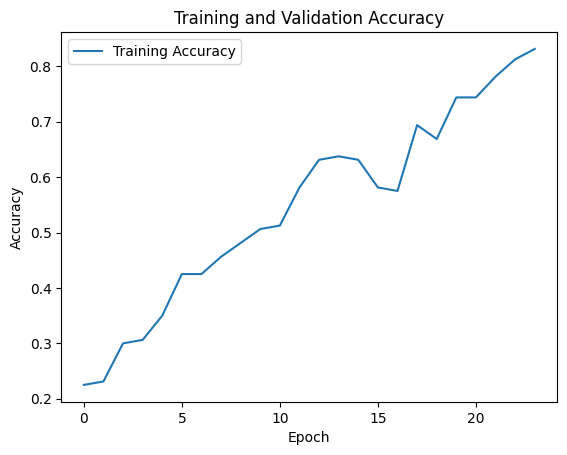

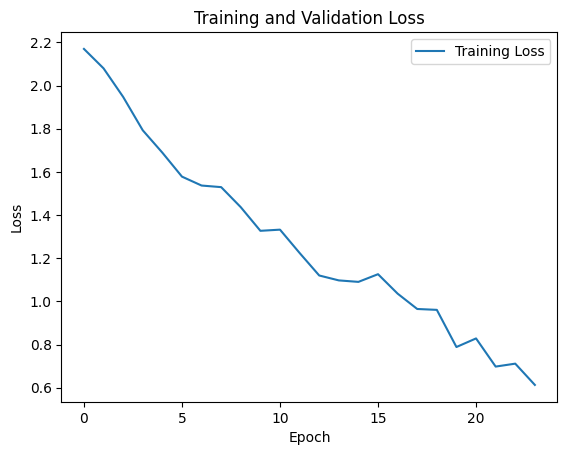

In [35]:

# Train the model and store the training history
# history = model.fit(X_train, y_train, epochs=24, batch_size=400, validation_data=(X_test, y_test))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
def draw_confusion_matrix(matrix):
    green = (30, 200, 40, 160)
    red = (255, 25, 0, 140)

    x = matrix.shape[1]
    y = matrix.shape[0]

    colors = [[green if i==j else red for i in range(x)] for j in range(y)]
    colors = np.array(colors).astype(np.uint8)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=90)
    ax.imshow(colors)

    ax.set_xticks(np.arange(x), labels=range(x))
    ax.set_yticks(np.arange(y), labels=range(y))

    ax.set_xticks(np.arange(-.5, x, 1), minor=True)
    ax.set_yticks(np.arange(-.5, y, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    ax.set_xlabel("prediction")
    ax.set_ylabel("label")

    for i in range(y):
        for j in range(x):
            text = ax.text(j, i, matrix[i][j], ha="center", va="center", color='black')

    ax.set_title("Confusion Matrix")
    fig.tight_layout()
    plt.show()

1/1 [==============================] - 0s 265ms/step


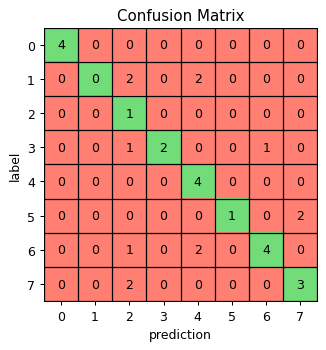

In [36]:
# Obtain predicted probabilities for the test set
probas = model.predict(X_test)
y_pred = np.argmax(probas, axis=-1)
y_pred_val = np.max(probas, axis=-1)
y_test_ = to_categorical(y_test, num_classes=8)

draw_confusion_matrix(
    confusion_matrix(y_test, y_pred)
)

In [37]:

# Convert probabilities to binary predictions using a threshold of 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.00      0.00      0.00         4
           2       0.14      1.00      0.25         1
           3       1.00      0.50      0.67         4
           4       0.50      1.00      0.67         4
           5       1.00      0.33      0.50         3
           6       0.80      0.57      0.67         7
           7       0.60      0.60      0.60         5

    accuracy                           0.59        32
   macro avg       0.63      0.63      0.54        32
weighted avg       0.68      0.59      0.59        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


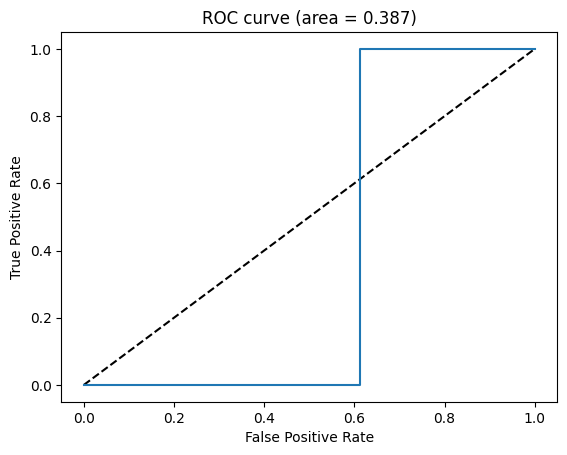

In [38]:
# Calculate the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_val, pos_label=2)

# Calculate the Area Under the Curve (AUC)
area_under_curve = auc(fpr, tpr)

# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random chance
plt.plot(fpr, tpr)  # Plot the actual ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.3f})'.format(area_under_curve))
plt.show()

In [26]:
from tensorflow.keras import layers, models

# Build the MobileNet-like model
modell = models.Sequential()

# Block 1
modell.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(128, 128, 3), activation='relu'))

# Block 2
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', activation='relu'))
modell.add(layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 3
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same', activation='relu'))
modell.add(layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 4
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', activation='relu'))
modell.add(layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 5
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same', activation='relu'))
modell.add(layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 6
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', activation='relu'))
modell.add(layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 7
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same', activation='relu'))
modell.add(layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 8
for _ in range(5):
    modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', activation='relu'))
    modell.add(layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 9
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same', activation='relu'))
modell.add(layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Block 10
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same', activation='relu'))
modell.add(layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='same', activation='relu'))

# Global Average Pooling
modell.add(layers.GlobalAveragePooling2D())

# Dense layer
modell.add(layers.Dense(8, activation='softmax'))

# Compile the model
modell.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
modell.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 depthwise_conv2d_39 (Depth  (None, 64, 64, 32)        320       
 wiseConv2D)                                                     
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 64)        2112      
                                                                 
 depthwise_conv2d_40 (Depth  (None, 32, 32, 64)        640       
 wiseConv2D)                                                     
                                                                 
 conv2d_54 (Conv2D)          (None, 32, 32, 128)       8320      
                                                                 
 depthwise_conv2d_41 (Depth  (None, 32, 32, 128)      

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build the MobileNet-like model
modell = models.Sequential()

# Conv Block 1
modell.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(128, 128, 3)))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 2
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 3
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 4
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 5
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 6
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 7
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Repeat Depthwise Separable Convolution Block 8 five times
for _ in range(5):
    modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
    modell.add(layers.BatchNormalization())
    modell.add(layers.Activation('relu'))
    modell.add(layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same'))
    modell.add(layers.BatchNormalization())
    modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 9
modell.add(layers.DepthwiseConv2D((3, 3), strides=(2, 2), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Depthwise Separable Convolution Block 10
modell.add(layers.DepthwiseConv2D((3, 3), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))
modell.add(layers.Conv2D(1024, (1, 1), strides=(1, 1), padding='same'))
modell.add(layers.BatchNormalization())
modell.add(layers.Activation('relu'))

# Global Average Pooling
modell.add(layers.GlobalAveragePooling2D())

# Dense layer
modell.add(layers.Dense(8, activation='softmax'))  # Assuming 8 classes for the output

# Compile the model
modell.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
modell.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_39 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_27 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_65 (Depth  (None, 64, 64, 32)        320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_40 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                      

In [52]:

# Train the model with specified batch size and epochs
# history = model.fit(X_train, y_train, epochs=13, batch_size=400, validation_data=(X_test, y_test))

history = modell.fit(augmented_train_images, augmented_train_labels, epochs=24, batch_size=256)


Epoch 1/24
1/1 [==============================] - 0s 318ms/step - loss: 1.7238 - accuracy: 0.5875
Epoch 2/24
1/1 [==============================] - 0s 215ms/step - loss: 0.1153 - accuracy: 0.9563
Epoch 3/24
1/1 [==============================] - 0s 212ms/step - loss: 0.0385 - accuracy: 0.9937
Epoch 4/24
1/1 [==============================] - 0s 214ms/step - loss: 0.0203 - accuracy: 1.0000
Epoch 5/24
1/1 [==============================] - 0s 220ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 6/24
1/1 [==============================] - 0s 199ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 7/24
1/1 [==============================] - 0s 196ms/step - loss: 0.0103 - accuracy: 1.0000
Epoch 8/24
1/1 [==============================] - 0s 199ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 9/24
1/1 [==============================] - 0s 197ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 10/24
1/1 [==============================] - 0s 195ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 11/24
1/1 [==

In [53]:
# Assuming you have loaded your 'tune' set into the variables `tune_images` and `tune_labels`

# Fine-tune the model on the 'tune' set
history = modell.fit(tune_images, tune_labels, epochs=13, batch_size=256)


Epoch 1/13
7/7 [==============================] - 2s 272ms/step - loss: 1.7550 - accuracy: 0.6288
Epoch 2/13
7/7 [==============================] - 2s 279ms/step - loss: 0.9933 - accuracy: 0.6500
Epoch 3/13
7/7 [==============================] - 2s 282ms/step - loss: 0.7456 - accuracy: 0.7613
Epoch 4/13
7/7 [==============================] - 2s 283ms/step - loss: 0.4208 - accuracy: 0.8794
Epoch 5/13
7/7 [==============================] - 2s 276ms/step - loss: 0.1952 - accuracy: 0.9494
Epoch 6/13
7/7 [==============================] - 2s 273ms/step - loss: 0.1384 - accuracy: 0.9625
Epoch 7/13
7/7 [==============================] - 2s 273ms/step - loss: 0.1446 - accuracy: 0.9606
Epoch 8/13
7/7 [==============================] - 2s 274ms/step - loss: 0.1211 - accuracy: 0.9638
Epoch 9/13
7/7 [==============================] - 2s 275ms/step - loss: 0.1408 - accuracy: 0.9588
Epoch 10/13
7/7 [==============================] - 2s 276ms/step - loss: 0.1098 - accuracy: 0.9681
Epoch 11/13
7/7 [==

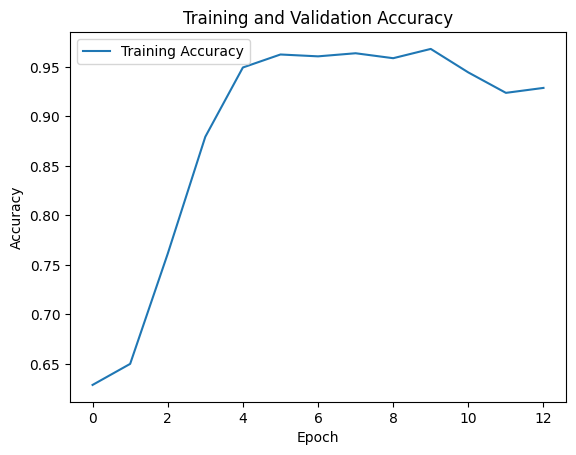

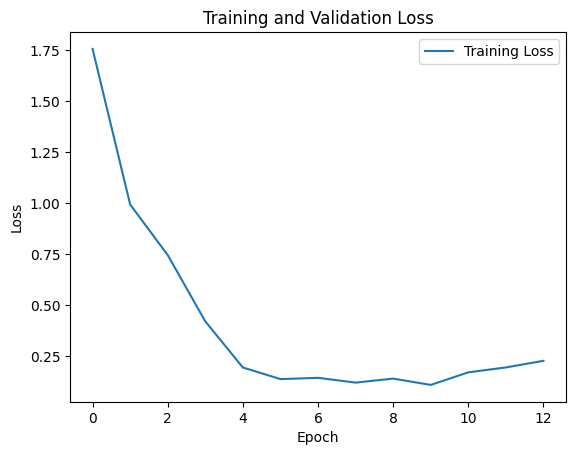

In [54]:

# Train the model and store the training history
# history = model.fit(X_train, y_train, epochs=24, batch_size=400, validation_data=(X_test, y_test))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
